# Extraction and cleanup of the refugee data

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
from tqdm import tqdm
import wikipedia
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import shapely.wkt


import folium
from folium.plugins import MarkerCluster
from folium import IFrame

In [2]:
CONFLICT_DATA_PATH = "ged171.csv"
raw_conflict_df = pd.read_csv(CONFLICT_DATA_PATH)
display(raw_conflict_df.head(5))

,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,gwnoa,...,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,low,high
0,4,2010,1,1,230,Yemen (North Yemen):Government,459,Government of Yemen (North Yemen) - AQAP,123,678.0,...,1,2010-09-25,2010-09-25,2,0,0,0,2,2,2
1,5,2011,1,3,715,Government of Yemen (North Yemen) - Civilians,1182,Government of Yemen (North Yemen) - Civilians,123,678.0,...,1,2011-02-19,2011-02-19,0,0,0,0,0,0,2
2,6,2011,1,1,230,Yemen (North Yemen):Government,459,Government of Yemen (North Yemen) - AQAP,123,678.0,...,1,2011-04-16,2011-04-16,0,0,0,0,0,0,1
3,7,2012,1,1,230,Yemen (North Yemen):Government,459,Government of Yemen (North Yemen) - AQAP,123,678.0,...,1,2012-06-04,2012-06-04,4,1,0,0,5,5,5
4,10,2012,1,1,230,Yemen (North Yemen):Government,459,Government of Yemen (North Yemen) - AQAP,123,678.0,...,1,2012-12-09,2012-12-09,0,4,1,0,5,5,5


In [3]:
for year in raw_conflict_df.year.unique():
    for conflict_new_id in raw_conflict_df[raw_conflict_df.year == year].conflict_new_id.unique():
        subdf = raw_conflict_df[(raw_conflict_df.year == year) & (raw_conflict_df.year == year)]

In [4]:
print(raw_conflict_df.columns)

Index(['id', 'year', 'active_year', 'type_of_violence', 'conflict_new_id',
       'conflict_name', 'dyad_new_id', 'dyad_name', 'side_a_new_id', 'gwnoa',
       'side_a', 'side_b_new_id', 'gwnob', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates', 'adm_1', 'adm_2',
       'latitude', 'longitude', 'geom_wkt', 'priogrid_gid', 'country',
       'country_id', 'region', 'event_clarity', 'date_prec', 'date_start',
       'date_end', 'deaths_a', 'deaths_b', 'deaths_civilians',
       'deaths_unknown', 'best', 'low', 'high'],
      dtype='object')


In [5]:
# TODO: explain why we keep what
KEPT_COLUMNS= ['year', 'type_of_violence', 'conflict_new_id',
       'conflict_name', 'side_a_new_id', 'gwnoa',
       'side_a', 'gwnob', 'side_b_new_id','side_b',
       'where_prec', 'where_coordinates', 'adm_1', 'adm_2',
       'latitude', 'longitude', 'geom_wkt','country',
       'country_id','date_start', 'deaths_a', 'deaths_b',
       'deaths_civilians',
       'deaths_unknown', 'best'] 

In [6]:
conflict_df = raw_conflict_df[KEPT_COLUMNS]

In [7]:
conflict_df = conflict_df.replace(to_replace="-[0-9]{2}-[0-9]{2}", value="", regex=True)

In [8]:
conflict_df.head(5)

,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,side_b,...,longitude,geom_wkt,country,country_id,date_start,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best
0,2010,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,AQAP,...,44.206667,POINT (44.206667 15.354722),Yemen (North Yemen),678,2010,2,0,0,0,2
1,2011,3,715,Government of Yemen (North Yemen) - Civilians,123,678.0,Government of Yemen (North Yemen),NaN,1,Civilians,...,45.036667,POINT (45.036667 12.779444),Yemen (North Yemen),678,2011,0,0,0,0,0
2,2011,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,AQAP,...,46.141765,POINT (46.141765 13.786202),Yemen (North Yemen),678,2011,0,0,0,0,0
3,2012,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,AQAP,...,46.141765,POINT (46.141765 13.786202),Yemen (North Yemen),678,2012,4,1,0,0,5
4,2012,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,AQAP,...,45.300000,POINT (45.300000 15.616667),Yemen (North Yemen),678,2012,0,4,1,0,5


In [10]:
geometry = conflict_df['geom_wkt'].map(shapely.wkt.loads)
conflict_df = conflict_df.drop('geom_wkt', axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(conflict_df, crs=crs, geometry=geometry)


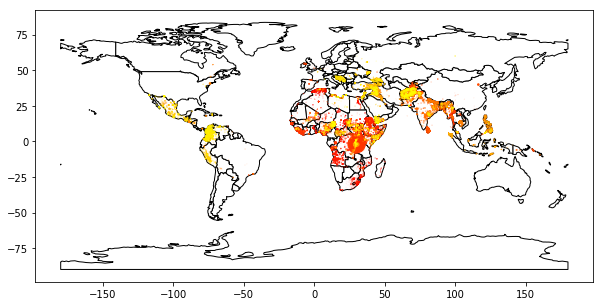

In [11]:
#for row in list(gdf.index.values):
#    print(gdf.get_value(row,"best"))
#    gdf[row].plot(s=gdf.get_value(row, "best"))
#    break
fig, ax = plt.subplots(figsize=(10,5))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


world.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, markersize=(gdf.loc[:, "best"]/1000), cmap="autumn")
    
plt.show()

In [12]:
m = folium.Map(tiles='cartodbpositron')

In [13]:
geojson_gdf = gdf[:10].to_crs(epsg='4326').to_json()
points = folium.features.GeoJson(geojson_gdf)
m.add_child(points)

In [14]:
table = """
<!DOCTYPE html>
<html>
<head>
<style>
table {{
    width:100%;
}}
table, th, td {{
    border: 1px solid black;
    border-collapse: collapse;
}}
th, td {{
    padding: 5px;
    text-align: left;
}}
table#t01 tr:nth-child(odd) {{
    background-color: #eee;
}}
table#t01 tr:nth-child(even) {{
   background-color:#fff;
}}
</style>
</head>
<body>

<table id="t01">
  <tr>
    <td>Type</td>
    <td>{}</td>
  </tr>
  <tr>
    <td>Name</td>
    <td>{}</td>
  </tr>
  <tr>
    <td>Nbr</td>
    <td>{}</td>
  </tr>
</table>
</body>
</html>
""".format

In [17]:
m = folium.Map(tiles='cartodbpositron')

width, height = 310,110
popups, locations = [], []
print("Rows to parse:{}".format(len(gdf)))
for idx, row in tqdm(gdf.iterrows()):
    locations.append([row['geometry'].y, row['geometry'].x])
    name = row['conflict_name'].encode('ascii', 'xmlcharrefreplace')
    deaths = row['best']
    iframe = folium.IFrame(table('Deaths', name, deaths), width=width, height=height)
    popups.append(iframe)



0it [00:00, ?it/s]
20it [00:00, 198.67it/s]

Rows to parse:135181



64it [00:00, 317.86it/s]
109it [00:00, 361.62it/s]
158it [00:00, 392.70it/s]
209it [00:00, 415.68it/s]
264it [00:00, 437.43it/s]
315it [00:00, 446.49it/s]
361it [00:00, 447.55it/s]
407it [00:00, 446.50it/s]
458it [00:01, 452.33it/s]
511it [00:01, 458.93it/s]
563it [00:01, 463.29it/s]
613it [00:01, 462.25it/s]Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/lal/Programs/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/lal/Programs/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/lal/Programs/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

135181it [04:08, 545.01it/s]


KeyboardInterrupt: 

In [18]:
h = folium.FeatureGroup(name='Deaths')
h.add_child(MarkerCluster(locations=locations, popups=popups))
m.add_child(h)

KeyboardInterrupt: 